# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# 2. Loading The Data

In [3]:
data_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
classes = ['no', 'yes']
img_size = 224

X = []
Y = []
for c in classes:
    path = os.path.join(data_path, c)
    class_num = classes.index(c)
    for img in os.listdir(path):
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        img_arr = cv2.resize(img_arr, (img_size, img_size))
        X.append(img_arr)
        Y.append(class_num)

X = np.array(X)
Y = np.array(Y)
Y = to_categorical(Y, num_classes=len(classes))

The to_categorical(Y, num_classes=len(classes)) function converts these numeric labels (0 or 1) into one-hot encoded vectors. This is a common way to represent class labels in many machine learning tasks, especially in classification problems where there are multiple classes. It ensures that the model can understand and learn from these labels effectively. In this case, it encodes "no" as [1, 0] and "yes" as [0, 1], making it suitable for Binary Classification

# 3. Splitting The Data

In [37]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [46]:
print("X_val shape:", X_train.shape)
print("Y_val shape:", Y_train.shape)

X_val shape: (202, 224, 224, 3)
Y_val shape: (202, 2)


In [38]:
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

X_val shape: (51, 224, 224, 3)
Y_val shape: (51, 2)


# 4. Model VGG16

### Why it was the best to work with VGG16:
1- Simplicity and Depth: VGG16 has a relatively simple and uniform architecture compared to more complex models like Inception or ResNet. It consists of 13 convolutional layers followed by three fully connected layers. The simplicity can be an advantage when you have limited data because it reduces the risk of overfitting. Fewer layers mean fewer parameters to learn, making it less prone to overfitting small datasets.

2-Transfer Learning: VGG16 has been pre-trained on a large-scale image classification dataset (ImageNet). Transfer learning allows you to leverage the knowledge gained from this pre-training when working with a small dataset. By fine-tuning the model's weights on your specific task, you can benefit from features learned from a diverse set of images, which can be especially useful when you have limited brain tumor images.

3- Proven Performance: While VGG16 may not be the most state-of-the-art architecture for image segmentation, it has shown good performance in various computer vision tasks, including image segmentation. Its simplicity makes it a reliable choice when you don't have the computational resources or the data to experiment with more complex models.

4- Adaptability: You can fine-tune VGG16 by adding custom layers or modifying the existing ones to suit your specific segmentation task. This adaptability allows you to tailor the model to the characteristics of your brain tumor dataset.

#### We conclude from this that it is the best choice for our data as it is not big and not complex.

### Train and Compile

In [6]:
base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
predictions1 = Dense(len(classes), activation='softmax')(x1)


model = Model(inputs=base_model1.input, outputs=predictions1)

#
for layer in base_model1.layers:
    layer.trainable = False

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

batch_size = 32
epochs = 30

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1,
                    validation_data=(X_val,Y_val))


Epoch 1/30
7/7 [==============================] - 77s 11s/step - loss: 3.5350 - accuracy: 0.6089 - val_loss: 1.9340 - val_accuracy: 0.6863
Epoch 2/30
7/7 [==============================] - 79s 12s/step - loss: 2.0106 - accuracy: 0.7327 - val_loss: 0.9088 - val_accuracy: 0.8235
Epoch 3/30
7/7 [==============================] - 74s 11s/step - loss: 0.2842 - accuracy: 0.9158 - val_loss: 0.1450 - val_accuracy: 0.9216
Epoch 6/30
7/7 [==============================] - 73s 11s/step - loss: 0.1903 - accuracy: 0.9208 - val_loss: 0.0770 - val_accuracy: 0.9412
Epoch 7/30
7/7 [==============================] - 72s 10s/step - loss: 0.3136 - accuracy: 0.9257 - val_loss: 0.1216 - val_accuracy: 0.9608
Epoch 8/30
7/7 [==============================] - 69s 10s/step - loss: 0.1688 - accuracy: 0.9307 - val_loss: 0.1441 - val_accuracy: 0.9020
Epoch 9/30
7/7 [==============================] - 70s 10s/step - loss: 0.2160 - accuracy: 0.9208 - val_loss: 0.1820 - val_accuracy: 0.9412
Epoch 10/30
7/7 [==========

### Predictions and Evaluation

In [8]:
y_pred = model.predict(X_val)

threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

accuracy = accuracy_score(Y_val, y_pred_binary)

print("Accuracy", accuracy)

2/2 [==============================] - 14s 5s/step
Accuracy 0.9411764705882353


In [10]:
class_report = classification_report(Y_val, y_pred_binary)

print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.94      0.97      0.95        31

   micro avg       0.94      0.94      0.94        51
   macro avg       0.94      0.93      0.94        51
weighted avg       0.94      0.94      0.94        51
 samples avg       0.94      0.94      0.94        51



In [33]:
y_pred_binary.shape

(51, 2)

In [35]:
y_pred_classes = np.argmax(y_pred, axis=1)

y_pred_classes

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1])

In [45]:
Y_val.shape

(51, 2)

In [39]:
y_val_classes = np.argmax(Y_val, axis=1)
y_val_classes

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1])

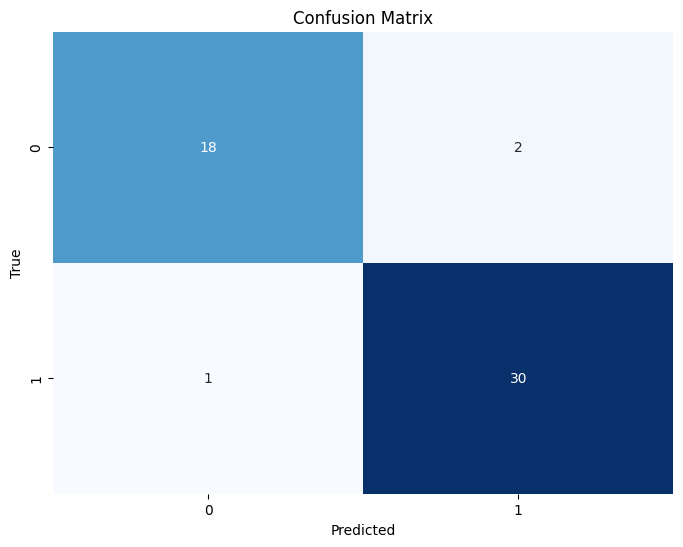

In [41]:
confusion = confusion_matrix(y_val_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Save

In [13]:
model.save('my_model_acc94.h5')

In [ ]:
import pickle

# Save the model using pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)